In [8]:
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import networkx as nx
import scipy.io as sio
import networkx as nx
import seaborn as sns
from scipy.signal import coherence, hilbert
import scipy.io

In [1]:
import mne

raw = mne.io.read_raw_edf(
    r"C:\Users\rayom\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf",
    preload=True)

print(raw)
print(raw.info)

Extracting EDF parameters from C:\Users\rayom\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\rayom\AppData\Local\Temp\ipykernel_15924\2177790066.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(


<RawEDF | chb01_01.edf, 23 x 921600 (3600.0 s), ~161.7 MiB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2076-11-06 11:42:54 UTC
 nchan: 23
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: Surrogate>
>


In [10]:
import bct

eeg_channels = [ch for ch in raw.ch_names if 'EEG' in ch];
raw_eeg = raw.copy().pick_channels(eeg_channels, ordered=True);
variances = raw_eeg.get_data().var(axis=1);
variance_threshold = 1e-10
low_variance_channels = [raw_eeg.ch_names[i] for i, var in enumerate(variances) if var < variance_threshold];
raw_eeg.drop_channels(low_variance_channels);
raw_eeg.set_eeg_reference('average', projection=True);
raw_eeg.apply_proj();
l_freq, h_freq = 1, 40
raw_eeg.filter(l_freq, h_freq, fir_design='firwin');
preprocessed_data = raw_eeg.get_data();

connectivity_matrix = np.corrcoef(preprocessed_data);
connectivity_matrix_df = pd.DataFrame(connectivity_matrix);
connectivity_matrix_df.fillna(0, inplace=True);
connectivity_matrix_df.replace([np.inf, -np.inf], 0, inplace=True);

G_edf = nx.from_numpy_array(connectivity_matrix_df.values);


# GRADOS NODOS
edf_degrees = dict(G_edf.degree())
print("Grados de los nodos:", edf_degrees)

# EFICIENCIA GLOBAL
edf_global_efficiency = bct.efficiency_wei(connectivity_matrix_df.values)
print("Eficiencia global:", edf_global_efficiency)

# EFICIENCIA LOCAL
edf_local_efficiency = bct.efficiency_wei(connectivity_matrix_df.values, local=True)
print("Eficiencia local:", edf_local_efficiency)

# COEFICIENTE DE CLUSTER
edf_clustering_coefficient = nx.average_clustering(G_edf)
print("Coeficiente de cluster:", edf_clustering_coefficient)

# RUTA MÁS CORTA
if nx.is_connected(G_edf):
    edf_avg_shortest_path_length = nx.average_shortest_path_length(G_edf)
    print("Ruta más corta:", edf_avg_shortest_path_length)


# MUNDO PEQUEÑO
n_nodes_edf = G_edf.number_of_nodes()
n_edges_edf = G_edf.number_of_edges()
G_random_edf = nx.gnm_random_graph(n_nodes_edf, n_edges_edf)
clustering_coefficient_random_edf = nx.average_clustering(G_random_edf)
print("Coeficiente de cluster (Random):", clustering_coefficient_random_edf)
if nx.is_connected(G_random_edf):
    avg_shortest_path_length_random_edf = nx.average_shortest_path_length(G_random_edf)
    print("Ruta más corta (Random):", avg_shortest_path_length_random_edf)


if avg_shortest_path_length_random_edf > 0 and edf_avg_shortest_path_length > 0 and clustering_coefficient_random_edf > 0:
    small_world_coefficient_edf = (edf_clustering_coefficient / clustering_coefficient_random_edf) / (edf_avg_shortest_path_length / avg_shortest_path_length_random_edf)
    print("Coeficiente de mundo pequeño:", small_world_coefficient_edf)


import community.community_louvain as community_louvain
# COMUNIDADES
G_edf_abs = nx.from_numpy_array(np.abs(connectivity_matrix_df.values))
edf_partition = community_louvain.best_partition(G_edf_abs)
print("Comunidades:", edf_partition)

# HUBS
edf_degrees_abs = dict(G_edf_abs.degree())
edf_avg_degree_abs = np.mean(list(edf_degrees_abs.values()))
edf_hubs_abs = [node for node, degree in edf_degrees_abs.items() if degree > edf_avg_degree_abs]
print("Hubs", edf_hubs_abs)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Grados de los nodos: {0: 24, 

C:\Users\rayom\AppData\Local\Temp\ipykernel_15924\3859588651.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('hot')


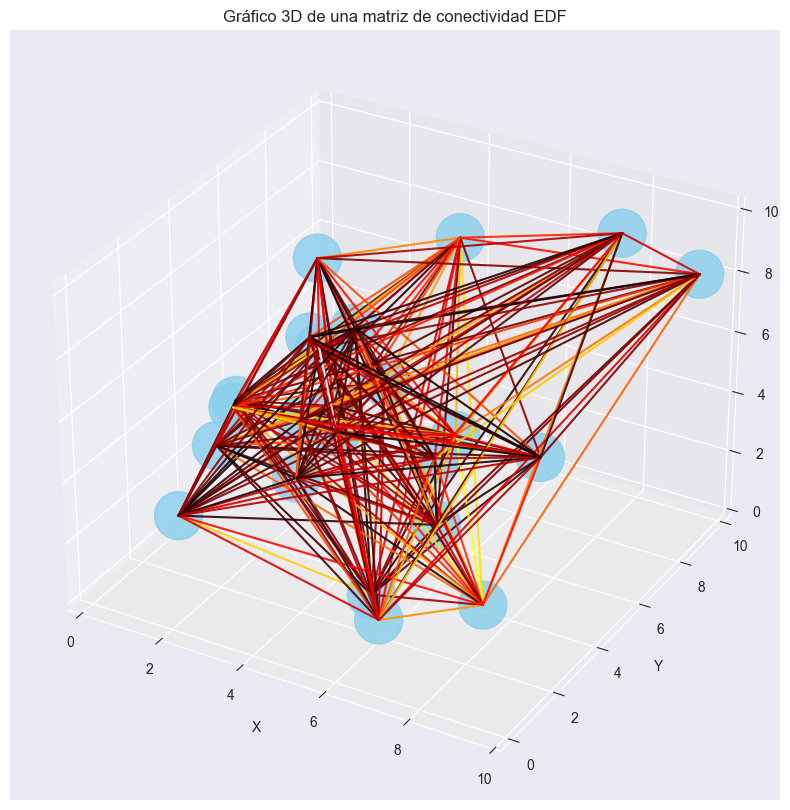

In [27]:
import cm
import matplotlib.cm as cm

num_nodes = G_edf.number_of_nodes()

np.random.seed(42)
coords_edf = np.random.rand(num_nodes, 3) * 10

edf_degrees = dict(G_edf.degree())
node_size_factor = 50
node_sizes_edf = [edf_degrees[node] * node_size_factor for node in G_edf.nodes()]

edge_weights_edf = np.array([G_edf[u][v]['weight'] for u, v in G_edf.edges()])
abs_edge_weights_edf = np.abs(edge_weights_edf)

if np.max(abs_edge_weights_edf) != np.min(abs_edge_weights_edf):
    norm_edge_colors_edf = (abs_edge_weights_edf - np.min(abs_edge_weights_edf)) / (
                np.max(abs_edge_weights_edf) - np.min(abs_edge_weights_edf))
else:
    norm_edge_colors_edf = np.zeros_like(abs_edge_weights_edf)

cmap = cm.get_cmap('hot')
edge_colors_edf = cmap(norm_edge_colors_edf)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

node_xyz_edf = coords_edf

ax.scatter(node_xyz_edf[:, 0], node_xyz_edf[:, 1], node_xyz_edf[:, 2], s=node_sizes_edf, c='skyblue', alpha=0.8)

for i, (u, v) in enumerate(G_edf.edges()):
    x = np.array([coords_edf[u, 0], coords_edf[v, 0]])
    y = np.array([coords_edf[u, 1], coords_edf[v, 1]])
    z = np.array([coords_edf[u, 2], coords_edf[v, 2]])
    ax.plot(x, y, z, color=edge_colors_edf[i], alpha=0.9)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Gráfico 3D de una matriz de conectividad EDF')

plt.show()

Como hacer el hub mas grande y que las comunidades esten del mismo color